# Buy/Sell signals for the Mexican Equity Index
## Alfonso Camacho Bustillo - 28 Jul 2024

### The goal of this project is to test different ML models to generate Buy/Sell signals for an Equity Index, in this the case of the Mexican Bolsa index. The models are built based on daily public data from the exchange, a set of technical indicators on that same index and some basic data of the Mexican currency, Interest Rates and VIX (US Volatility index) as an additional market sentiment reference.

# Data preparation
Source data:
* Mexican Bolsa Index and VIX index: Yahoo finance
* Technical Indicators : computed here
* FX and Rate volatility: Mexican Central Bank web page

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pathlib as pl
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.base import clone
import seaborn as sns
from sklearn.metrics import accuracy_score

### Directories

In [125]:
def validate_file(file_path):
    """
    Validate if the file exists.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

def save_data(df, directory, base_name):
    """
    Save the DataFrame to a CSV file with a timestamp in the filename.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    file_name = f"{base_name}_{timestamp}.csv"
    file_path = os.path.join(directory, file_name)

    df.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")



### Load and clean data

In [128]:
def load_data(file_path):
    """
    Load data from a CSV file and provide initial exploratory statistics.
    """
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)

    #Ensure numerical format
    numeric_columns = ['FX', 'FX_ch%_1d', 'FX_ch%_2d','FX_ch%_5d','VIX_ch_1d','VIX_ch_5d']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')# Check for NA values
    
    # Provide initial exploratory statistics
    print("Initial Exploratory Statistics:")
    print(df.describe())
    print("\nDatabase Size:")
    print(df.shape)
    print("\nInitial Exploration of Errors:")
    print("NA Values:")
    print(df.isna().sum())
    # Check for erroneous data
    print("Potential Erroneous Data (e.g., negative prices or volumes):")
    print(df[(df['Open'] <= 0) | (df['High'] <= 0) | (df['Low'] <= 0) | (df['Close'] <= 0) | (df['Volume'] <= 0)].head())

    return df

def clean_data(df):
    """
    Clean the data by dropping NA values and filtering erroneous data.
    """
    # Drop rows with any NA values
    df.dropna(inplace=True)

    # Detect and handle erroneous data (e.g., negative prices or volumes)
    df = df[(df['Open'] > 0) & (df['High'] > 0) & (df['Low'] > 0) & (df['Close'] > 0) & (df['Volume'] > 0)]

    # Provide after-cleaning statistics
    print("\nAfter-Cleaning Statistics:")
    print(df.describe())
    print("\nDatabase Size After Cleaning:")
    print(df.shape)
    print("\nDataFrame Head After Cleaning:")
    print(df.head())

    return df


### Compute and categorize returns

In [131]:
def compute_returns(df,window=1):
    """
    Compute simple returns for the DataFrame over a specified window.
    """
    df[f'Simple_return_{window}'] = df['Close'].pct_change(periods=window)
    df.dropna(inplace=True)
    return df


def compute_lagged_returns(df, window, lag):
    # Function to compute lagged returns
    column_name = f'Lagged_Return_{window}_{lag}'
    df[column_name] = df['Close'].pct_change(periods=window).shift(lag)
    return df
    
def compute_forward_returns(df, X):
    """
    Compute forward returns based on a given forecast horizon (X days).
    """
    df['forward_return'] = df['Close'].shift(-X) / df['Close'] - 1
    df.dropna(inplace=True)
    return df

def categorize_returns(df, down_threshold=-0.05):
    """
    Categorize forward returns into 'down' and 'not_down' based on thresholds.
    """
    conditions = [
        (df['forward_return'] < down_threshold),
        (df['forward_return'] >= down_threshold)
    ]
    choices = [0,1]
    df['return_category'] = np.select(conditions, choices, default=1)
    return df


In [132]:
def compute_std_dev_close(df, window):
    """
    Compute the rolling standard deviation of 'Close' prices for a specified window.
    """
    df[f'std_dev_close_{window}'] = df['Close'].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

def compute_std_dev_returns(df, window):
    """
    Compute the rolling standard deviation of daily returns for a specified window without storing daily returns.
    """
    daily_returns = df['Close'].pct_change()
    df[f'std_dev_return_{window}'] = daily_returns.rolling(window=window).std()
    df.dropna(inplace=True)
    return df

def compute_lag_value(df, column, lag):
    """
    Compute the value of the observation x-days before the current observation for a specified column.
    """
    df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    df.dropna(inplace=True)
    return df

### Functions to define Technical Indicators

In [136]:
# Moving Average (MA)
def compute_sma(df, window):
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

# Exponential Moving Average (EMA)
def compute_ema(df, window):
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

# Weighted Moving Average (WMA)
def compute_wma(df, window):
    weights = np.arange(1, window + 1)
    df[f'WMA_{window}'] = df['Close'].rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df

# Function to compute relative moving averages
def compute_relative_moving_averages(df):
    ma_columns = [col for col in df.columns if 'MA' in col and 'Relative' not in col]
    for col in ma_columns:
        df[f'Relative_{col}'] = df[col] / df['Close']
    return df


In [137]:
# Relative Strength Index (RSI)
def compute_rsi(df, window=14):
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

# Moving Average Convergence Divergence (MACD)
def compute_macd(df, fast=12, slow=26, signal=9):
    df[f'MACD_{fast}_{slow}'] = df['Close'].ewm(span=fast, adjust=False).mean() - df['Close'].ewm(span=slow, adjust=False).mean()
    df[f'MACD_Signal_{signal}'] = df[f'MACD_{fast}_{slow}'].ewm(span=signal, adjust=False).mean()
    df[f'MACD_Hist_{fast}_{slow}_{signal}'] = df[f'MACD_{fast}_{slow}'] - df[f'MACD_Signal_{signal}']
    return df

# Bollinger Bands
def compute_bollinger_bands(df, window=20, num_std=2):
    df[f'BB_Middle_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'BB_Upper_{window}'] = df[f'BB_Middle_{window}'] + num_std * df['Close'].rolling(window=window).std()
    df[f'BB_Lower_{window}'] = df[f'BB_Middle_{window}'] - num_std * df['Close'].rolling(window=window).std()
    return df

# Stochastic Oscillator
def compute_stochastic_oscillator(df, window=14):
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df[f'%K_{window}'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df[f'%D_{window}'] = df[f'%K_{window}'].rolling(window=3).mean()
    return df

# Average Directional Index (ADX)
def compute_adx(df, window=14):
    tr = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())))
    dm_plus = np.where((df['High'] - df['High'].shift()) > (df['Low'].shift() - df['Low']), df['High'] - df['High'].shift(), 0)
    dm_minus = np.where((df['Low'].shift() - df['Low']) > (df['High'] - df['High'].shift()), df['Low'].shift() - df['Low'], 0)
    di_plus = 100 * (pd.Series(dm_plus).ewm(alpha=1/window, min_periods=window).mean() / pd.Series(tr).ewm(alpha=1/window, min_periods=window).mean())
    di_minus = 100 * (pd.Series(dm_minus).ewm(alpha=1/window, min_periods=window).mean() / pd.Series(tr).ewm(alpha=1/window, min_periods=window).mean())
    dx = 100 * abs((di_plus - di_minus) / (di_plus + di_minus))
    df[f'ADX_{window}'] = dx.ewm(alpha=1/window, min_periods=window).mean()
    return df

# On-Balance Volume (OBV)
def compute_obv(df):
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df

# Function to compute OBV changes for different periods
def compute_obv_changes(df, periods):
    for period in periods:
        df[f'OBV_Change_{period}'] = df['OBV'].diff(periods=period)
    return df

# Parabolic SAR (Stop and Reverse)
def compute_parabolic_sar(df, initial_af=0.02, max_af=0.2):
    df['SAR'] = np.nan
    df['trend'] = 1
    df.iloc[0, df.columns.get_loc('SAR')] = df.iloc[0]['Low']
    ep = df.iloc[0]['High'] if df.iloc[0]['trend'] == 1 else df.iloc[0]['Low']
    af = initial_af

    for i in range(1, len(df)):
        prev_sar = df.iloc[i-1]['SAR']
        if df.iloc[i-1]['trend'] == 1:
            new_sar = prev_sar + af * (ep - prev_sar)
            new_sar = min(new_sar, df.iloc[i-1]['Low'], df.iloc[i]['Low'])
        else:
            new_sar = prev_sar - af * (prev_sar - ep)
            new_sar = max(new_sar, df.iloc[i-1]['High'], df.iloc[i]['High'])

        df.iloc[i, df.columns.get_loc('SAR')] = new_sar

        if df.iloc[i]['trend'] == 1 and df.iloc[i]['Low'] < new_sar:
            df.iloc[i, df.columns.get_loc('trend')] = -1
            df.iloc[i, df.columns.get_loc('SAR')] = ep
            ep = df.iloc[i]['Low']
            af = initial_af
        elif df.iloc[i]['trend'] == -1 and df.iloc[i]['High'] > new_sar:
            df.iloc[i, df.columns.get_loc('trend')] = 1
            df.iloc[i, df.columns.get_loc('SAR')] = ep
            ep = df.iloc[i]['High']
            af = initial_af
        else:
            if df.iloc[i]['trend'] == 1:
                if df.iloc[i]['High'] > ep:
                    ep = df.iloc[i]['High']
                    af = min(af + initial_af, max_af)
            else:
                if df.iloc[i]['Low'] < ep:
                    ep = df.iloc[i]['Low']
                    af = min(af + initial_af, max_af)

    return df

# Commodity Channel Index (CCI)
def compute_cci(df, window=50):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    tp_sma = tp.rolling(window=window).mean()
    mad = tp.rolling(window=window).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df[f'CCI_{window}'] = (tp - tp_sma) / (0.015 * mad)
    return df

# Average True Range (ATR)
def compute_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df[f'ATR_{window}'] = true_range.rolling(window=window).mean()
    return df

# Close Location Value (CLV)
def compute_clv(df):
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    return df

# Williams %R
def compute_williams_r(df, window=14):
    high_max = df['High'].rolling(window=window).max()
    low_min = df['Low'].rolling(window=window).min()
    df[f'Williams_%R_{window}'] = -100 * (high_max - df['Close']) / (high_max - low_min)
    return df

# Chaikin Oscillator
def compute_chaikin_oscillator(df, short_window=3, long_window=10):
    clv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    ad = clv * df['Volume']
    ad_ema_short = ad.ewm(span=short_window, adjust=False).mean()
    ad_ema_long = ad.ewm(span=long_window, adjust=False).mean()
    df[f'Chaikin_Oscillator_{short_window}_{long_window}'] = ad_ema_short - ad_ema_long
    return df

# Percentage Volume Oscillator (PVO)
def compute_pvo(df, short_window=12, long_window=26):
    short_ema = df['Volume'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Volume'].ewm(span=long_window, adjust=False).mean()
    df[f'PVO_{short_window}_{long_window}'] = 100 * (short_ema - long_ema) / long_ema
    return df

### Function to compute All technical indicators and pre-defined signals

In [139]:
def compute_technical_indicators_ma(df):
    # Compute Moving Averages
    sma_windows = [10, 20, 30, 50, 100, 200]
    ema_windows = [12, 20, 26, 50, 100]
    wma_windows = [10, 20, 50, 100]

    for window in sma_windows:
        df = compute_sma(df, window)

    for window in ema_windows:
        df = compute_ema(df, window)

    for window in wma_windows:
        df = compute_wma(df, window)

    # Compute relative moving averages
    df = compute_relative_moving_averages(df)

    return df

def compute_technical_indicators_osc(df):    
    # Compute RSI
    df = compute_rsi(df, window=14)
    df = compute_rsi(df, window=28)

    # Compute Bollinger Bands
    df = compute_bollinger_bands(df, window=20)
    df = compute_bollinger_bands(df, window=50)

    # Compute Stochastic Oscillator
    df = compute_stochastic_oscillator(df, window=14)
    df = compute_stochastic_oscillator(df, window=28)

    # Compute ADX
    df = compute_adx(df, window=14)
    df = compute_adx(df, window=28)

    # Compute OBV
    df = compute_obv(df)

    # OBV Changes for different periods
    df = compute_obv_changes(df, [1, 3, 5, 10])

    # Compute Parabolic SAR
    df = compute_parabolic_sar(df)

    # Compute CCI
    df = compute_cci(df, window=50)
    df = compute_cci(df, window=100)

    # Compute ATR
    df = compute_atr(df, window=14)
    df = compute_atr(df, window=28)

    # Compute CLV
    df = compute_clv(df)

    # Compute Williams %R
    df = compute_williams_r(df, window=14)
    df = compute_williams_r(df, window=28)

    # Compute Chaikin Oscillator
    df = compute_chaikin_oscillator(df, short_window=3, long_window=10)
    df = compute_chaikin_oscillator(df, short_window=5, long_window=15)

    # Compute PVO
    df = compute_pvo(df, short_window=12, long_window=26)
    df = compute_pvo(df, short_window=6, long_window=18)

    return df

In [141]:
def compute_technical_indicators_signals_new(df):
    # Ensure all required columns are present
    required_columns = ['SMA_50', 'SMA_200', 'EMA_20', 'EMA_50', 'EMA_12', 'EMA_26', 'RSI_14', 'RSI_28',
                        'BB_Upper_20', 'BB_Lower_20', 'BB_Upper_50', 'BB_Lower_50', '%K_14', '%K_28',
                        'ADX_14', 'ADX_28', 'OBV', 'SAR', 'CCI_50', 'CCI_100', 'Williams_%R_14', 'Williams_%R_28']

    for col in required_columns:
        if col not in df.columns:
            print(f"Column {col} is missing. Please ensure all required columns are present.")
            return df

    signals = pd.DataFrame(index=df.index)

    # 50-day SMA and 200-day SMA Crossover (Golden Cross and Death Cross)
    signals['SMA_50_200_Signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, np.where(df['SMA_50'] < df['SMA_200'], -1, 0))

    # 20-day EMA and 50-day EMA Crossover
    signals['EMA_20_50_Signal'] = np.where(df['EMA_20'] > df['EMA_50'], 1, np.where(df['EMA_20'] < df['EMA_50'], -1, 0))

    # 12-day EMA and 26-day EMA Crossover (MACD)
    macd_line = df['EMA_12'] - df['EMA_26']
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    df['MACD'] = macd_line
    df['MACD_SigLine'] = signal_line
    signals['EMA_12_26_Signal'] = np.where(macd_line > signal_line, 1, np.where(macd_line < signal_line, -1, 0))

    # 10-day SMA and 30-day SMA Crossover
    signals['SMA_10_30_Signal'] = np.where(df['SMA_10'] > df['SMA_30'], 1, np.where(df['SMA_10'] < df['SMA_30'], -1, 0))

    # RSI Signal
    signals['RSI_Signal_14'] = np.where(df['RSI_14'] < 30, 1, np.where(df['RSI_14'] > 70, -1, 0))
    signals['RSI_Signal_28'] = np.where(df['RSI_28'] < 30, 1, np.where(df['RSI_28'] > 70, -1, 0))

    # Bollinger Bands Signal
    signals['BB_Signal_20'] = np.where(df['Close'] > df['BB_Upper_20'], -1, np.where(df['Close'] < df['BB_Lower_20'], 1, 0))
    signals['BB_Signal_50'] = np.where(df['Close'] > df['BB_Upper_50'], -1, np.where(df['Close'] < df['BB_Lower_50'], 1, 0))

    # Stochastic Oscillator Signal
    signals['Stochastic_Signal_14'] = np.where(df['%K_14'] > 80, -1, np.where(df['%K_14'] < 20, 1, 0))
    signals['Stochastic_Signal_28'] = np.where(df['%K_28'] > 80, -1, np.where(df['%K_28'] < 20, 1, 0))

    # ADX Signal
    signals['ADX_Signal_14'] = np.where(df['ADX_14'] > 25, 1, 0)
    signals['ADX_Signal_28'] = np.where(df['ADX_28'] > 25, 1, 0)

    # OBV Signal
    df['OBV_Change'] = df['OBV'].diff()
    signals['OBV_Signal'] = np.where(df['OBV_Change'] > 0, 1, np.where(df['OBV_Change'] < 0, -1, 0))

    # Parabolic SAR Signal
    signals['SAR_Signal'] = np.where(df['Close'] > df['SAR'], 1, np.where(df['Close'] < df['SAR'], -1, 0))

    # CCI Signal
    signals['CCI_Signal_50'] = np.where(df['CCI_50'] > 100, 1, np.where(df['CCI_50'] < -100, -1, 0))
    signals['CCI_Signal_100'] = np.where(df['CCI_100'] > 100, 1, np.where(df['CCI_100'] < -100, -1, 0))

    # Williams %R Signal
    signals['Williams_%R_Signal_14'] = np.where(df['Williams_%R_14'] < -80, 1, np.where(df['Williams_%R_14'] > -20, -1, 0))
    signals['Williams_%R_Signal_28'] = np.where(df['Williams_%R_28'] < -80, 1, np.where(df['Williams_%R_28'] > -20, -1, 0))

    df = pd.concat([df, signals], axis=1)
    return df

### Function to clean and reorder final inputs

In [144]:
def clean_and_reorder_df(df):
    import re
    
    # Original columns
    original_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    return_columns = ['forward_return', 'return_category']
    
    # Technical indicator columns (excluding those containing '_Signal')
    technical_indicator_columns = [col for col in df.columns if '_Signal' not in col and col not in original_columns + return_columns]
    
    # Signal columns (containing '_Signal' anywhere)
    signal_columns = [col for col in df.columns if '_Signal' in col]

    # Combine all columns in the desired order
    ordered_columns = original_columns + return_columns + technical_indicator_columns + signal_columns
    
    # Reorder DataFrame columns
    df = df[ordered_columns].copy()
    
    # Final clean to remove rows with any missing values
    df.dropna(inplace=True)

    # List of temporary features to remove
    temporary_features = ['TR', '+DM', '-DM', 'DX_{window}', 'trend']
    # Remove temporary features
    df.drop(columns=[col for col in temporary_features if col in df.columns], inplace=True)
    
    # Create a DataFrame without '_Signal' columns
    df_inputs = df #df.drop(columns=signal_columns)  #** NO ELIMINO LOS SIGNALS A VER QUE PASA

    # Remove standard moving averages from final inputs
    ma_columns = [col for col in df_inputs.columns if 'MA' in col and 'Relative' not in col]
    df_inputs.drop(columns=ma_columns, inplace=True)

    return df, df_inputs

### Function to plot time series

In [147]:
def plot_time_series(df, column, plot_yearly=False):
    """
    Plot time series for the specified column. Optionally plot yearly blocks as matrix plots.
    """
    # Ensure the data is sorted by Date
    df = df.sort_values(by='Date')
    
    if plot_yearly:
        df['Year'] = df['Date'].dt.year
        years = df['Year'].unique()
        num_years = len(years)
        num_cols = 3
        num_rows = (num_years + num_cols - 1) // num_cols  # Ensure enough rows to fit all years
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharex=False, sharey=False)
        axes = axes.flatten()

        for i, year in enumerate(years):
            yearly_data = df[df['Year'] == year]
            sns.lineplot(data=yearly_data, x='Date', y=column, ax=axes[i])
            axes[i].set_title(f'{column} in {year}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(column)

        for j in range(i + 1, num_rows * num_cols):
            fig.delaxes(axes[j])  # Remove unused subplots

        plt.tight_layout()
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df, x='Date', y=column)
        plt.title(f'{column} Over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.show()


In [149]:
def clean_and_reorder_df(df):
    import re
    
    # Original columns
    original_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    return_columns = ['forward_return', 'return_category']
    
    # Technical indicator columns (excluding those containing '_Signal')
    technical_indicator_columns = [col for col in df.columns if '_Signal' not in col and col not in original_columns + return_columns]
    
    # Signal columns (containing '_Signal' anywhere)
    signal_columns = [col for col in df.columns if '_Signal' in col]

    # Combine all columns in the desired order
    ordered_columns = original_columns + return_columns + technical_indicator_columns + signal_columns
    
    # Reorder DataFrame columns
    df = df[ordered_columns].copy()
    
    # Final clean to remove rows with any missing values
    df.dropna(inplace=True)

    # List of temporary features to remove
    temporary_features = ['TR', '+DM', '-DM', 'DX_{window}', 'trend']
    # Remove temporary features
    df.drop(columns=[col for col in temporary_features if col in df.columns], inplace=True)
    
    # Create a DataFrame without '_Signal' columns
    df_inputs = df #df.drop(columns=signal_columns)  #** NO ELIMINO LOS SIGNALS A VER QUE PASA

    # Remove standard moving averages from final inputs
    ma_columns = [col for col in df_inputs.columns if 'MA' in col and 'Relative' not in col]
    df_inputs.drop(columns=ma_columns, inplace=True)

    return df, df_inputs

### Plot

In [154]:
def plot_time_series(df, column, plot_yearly=False):
    """
    Plot time series for the specified column. Optionally plot yearly blocks as matrix plots.
    """
    # Ensure the data is sorted by Date
    df = df.sort_values(by='Date')
    
    if plot_yearly:
        df['Year'] = df['Date'].dt.year
        years = df['Year'].unique()
        num_years = len(years)
        num_cols = 3
        num_rows = (num_years + num_cols - 1) // num_cols  # Ensure enough rows to fit all years
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharex=False, sharey=False)
        axes = axes.flatten()

        for i, year in enumerate(years):
            yearly_data = df[df['Year'] == year]
            sns.lineplot(data=yearly_data, x='Date', y=column, ax=axes[i])
            axes[i].set_title(f'{column} in {year}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(column)

        for j in range(i + 1, num_rows * num_cols):
            fig.delaxes(axes[j])  # Remove unused subplots

        plt.tight_layout()
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df, x='Date', y=column)
        plt.title(f'{column} Over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.show()


# ****************************

# MAIN - Data preparation

In [212]:
# Define the directory and file name
directory = "/Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/"
file_name = "DatosIPC.csv"

# Construct the file path
file_path = pl.Path(directory) / file_name

# Validate the file
validate_file(file_path)

# Load the data
df = load_data(file_path)

# Clean the data
df = clean_data(df)


/var/folders/t5/ptcpfwhx1x15711s2j4z27100000gn/T/ipykernel_4062/2838381351.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)


Initial Exploratory Statistics:
                                Date          Open          High  \
count                           5856   5800.000000   5800.000000   
mean   2012-10-21 20:20:24.590163968  33902.071607  34127.800097   
min              2001-05-04 00:00:00   5077.390137   5109.399902   
25%              2006-12-13 18:00:00  21235.715820  21476.148440   
50%              2012-10-08 12:00:00  38277.429685  38446.230470   
75%              2018-08-13 06:00:00  45498.065432  45743.771483   
max              2024-06-07 00:00:00  58856.230470  59020.550780   
std                              NaN  15274.750426  15351.615446   

                Low         Close        Volume           FX    FX_ch%_1d  \
count   5800.000000   5800.000000  5.800000e+03  5835.000000  5835.000000   
mean   33670.674219  33905.998673  1.605934e+08    14.629711     0.000156   
min     4950.709961   5081.919922  0.000000e+00     8.942800    -0.066590   
25%    21007.994140  21235.304200  1.040484e+08

## Compute Outputs - Forward returns and categories

In [215]:
#OUTPUTS

# Compute forward returns
X = 1  # Example: 5-day forecast horizon
df = compute_forward_returns(df, X)

# Categorize returns
#up_threshold = 0.02  # Example threshold for 'up' returns

down_threshold = -.00000000001 # Example threshold for 'down' returns
df = categorize_returns(df, down_threshold)


### Compute some lagged returns data

In [218]:
# Compute daily returns
simple_returns = [1,2,3,4,5,10,20]
for window in simple_returns:
    df = compute_returns(df, window)

# Compute st deviation of returns
st_windows = [5,10,20]
for window in st_windows:
    df = compute_std_dev_returns(df, window)
    
# Compute lagged value of returns
windows = [1, 5, 10]  # Example windows for lagged returns
lags = [1,2,3,5,10]  # Example lags
for window in windows:
    for lag in lags:
        df = compute_lagged_returns(df, window, lag)



### Compute all technical indicators

In [221]:
df=compute_technical_indicators_ma(df)

In [222]:
df=compute_technical_indicators_osc(df)

In [224]:
# Compute other Technical Indicator Signals
#df = compute_technical_indicators_signals_new(df) 
# IS JUST GENERATING NOISE AND IN ANY MODEL SHOW ANY RELEVANCE. WILL KEEP IT JUST IN CASE


In [225]:
#Clean and reorder data
df,df_inputs = clean_and_reorder_df(df)

In [226]:
# Directory to save files
save_directory = "/Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/"

# Save cleaned data
save_cleaned = True  # Set to True if you want to save the cleaned data
if save_cleaned:
    base_name = "V2_processed_data_ALL"
    save_data(df, save_directory, base_name)
    
# Save cleaned data
save_cleaned = True  # Set to True if you want to save the cleaned data
if save_cleaned:
    base_name = "V2_processed_data_Inputs"
    save_data(df_inputs, save_directory, base_name)  
       
    

Data saved to /Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/V2_processed_data_ALL_20240725_1833.csv
Data saved to /Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/V2_processed_data_Inputs_20240725_1833.csv


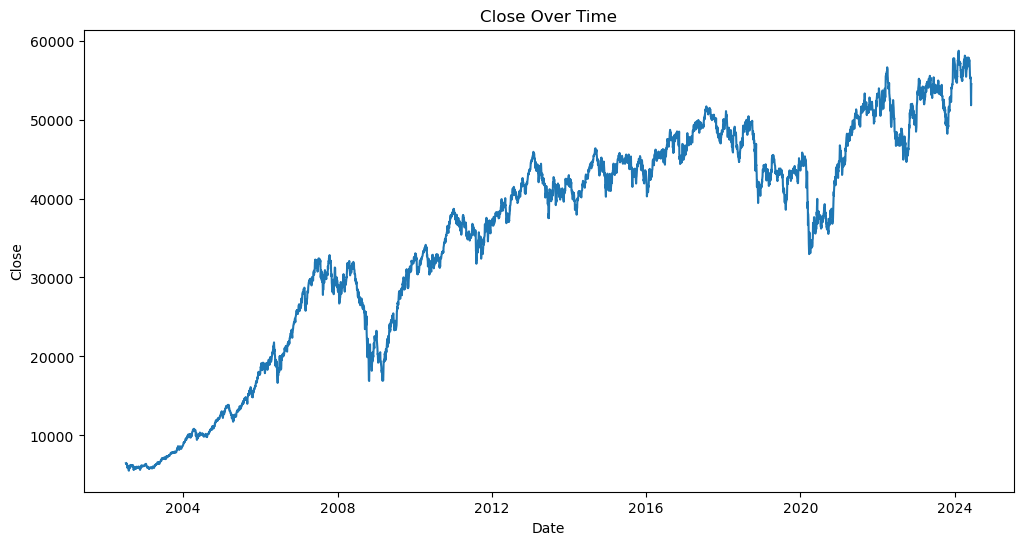

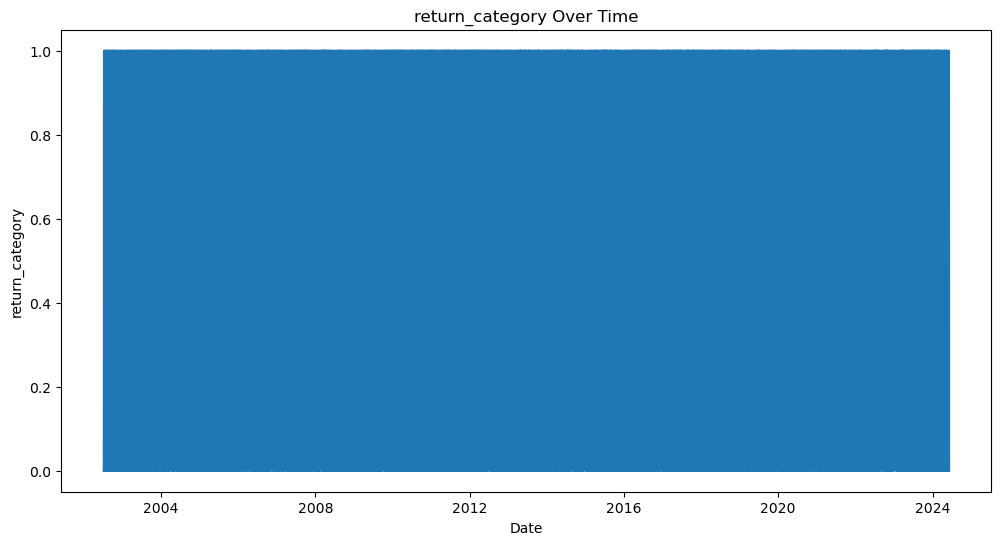

In [227]:
# Optional time series plots
plot_series = True # Set to True if you want to produce time series plots
if plot_series:
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Ensure 'Date' column is in datetime format
    plot_time_series(df, column='Close', plot_yearly=False)
    plot_time_series(df, column='return_category', plot_yearly=False)

# Reduce the matrix because of multicolinearity

In [229]:
# Function to compute the correlation matrix excluding specific columns
def compute_corr_matrix(df, exclude_cols):
    return df.drop(columns=exclude_cols).corr()

# Function to identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold=0.95):
    corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    high_corr_pairs = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)]
    return high_corr_pairs

# Function to remove highly correlated features
def remove_highly_correlated_features(df, high_corr_pairs):
    columns_to_drop = set()
    for index, value in high_corr_pairs.items():
        col1, col2 = index
        if col1 not in columns_to_drop and col2 not in columns_to_drop:
            # Drop one of the columns
            columns_to_drop.add(col2)
    df_reduced = df.drop(columns=columns_to_drop)
    return df_reduced, columns_to_drop

In [230]:
df_inputs.shape

(5302, 90)

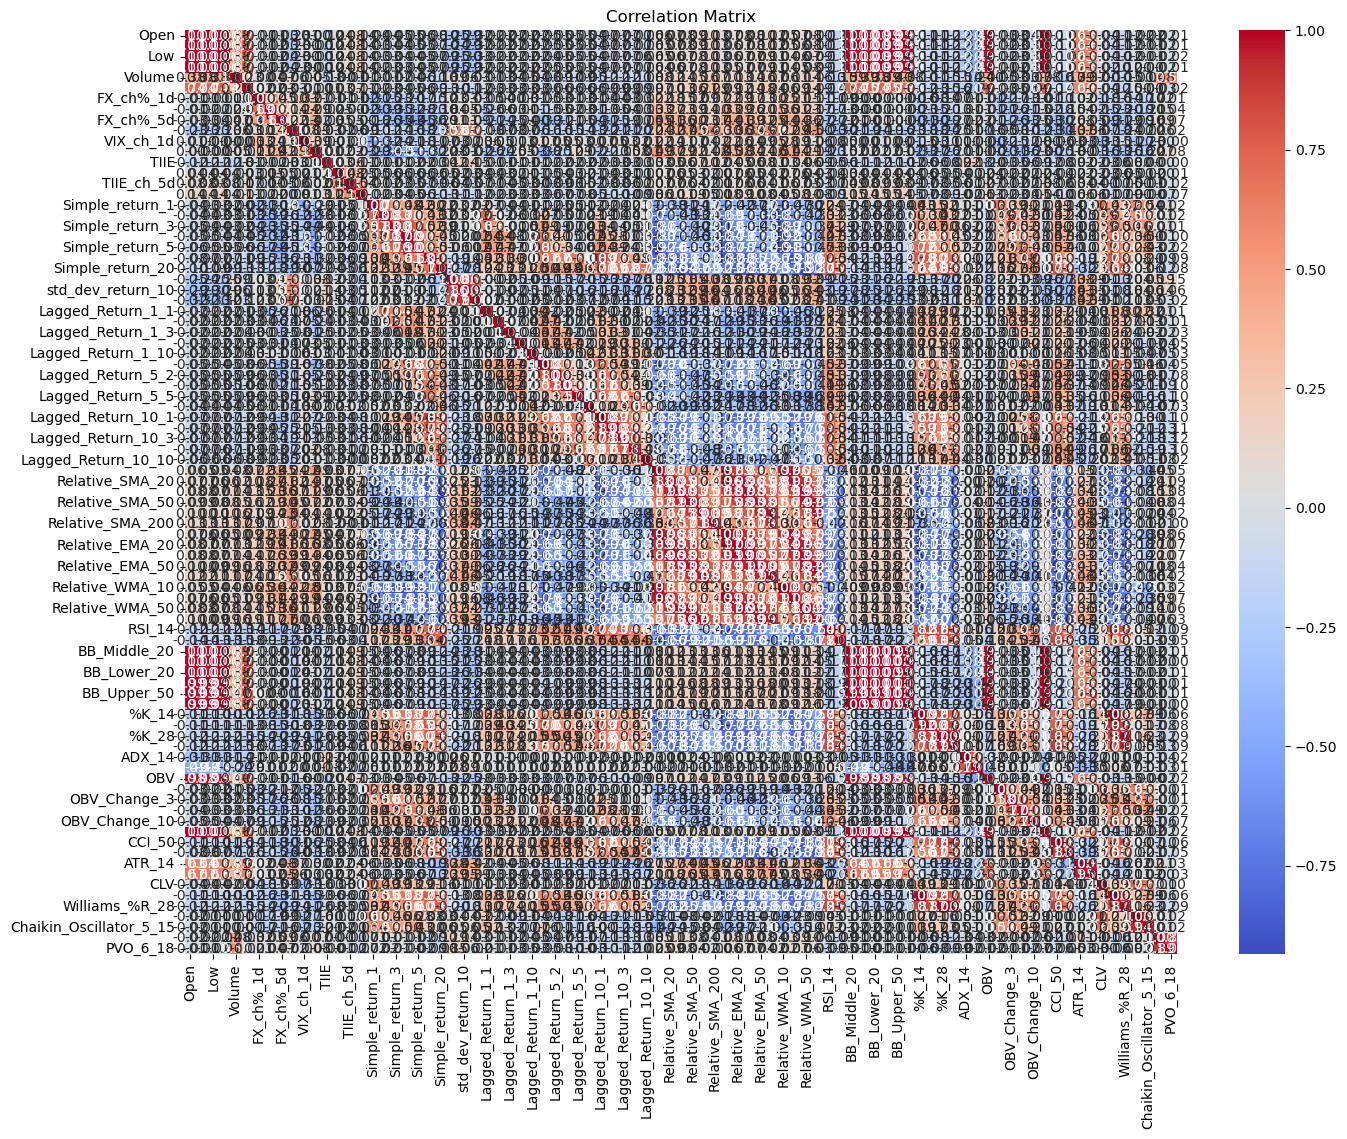

In [231]:
# Columns to exclude from correlation analysis
exclude_cols = ['Date', 'forward_return', 'return_category']

# Compute the correlation matrix excluding specific columns
corr_matrix = compute_corr_matrix(df_inputs, exclude_cols)

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [232]:
corr_matrix.shape

(87, 87)

In [233]:
# Identify highly correlated features
high_corr_pairs = get_highly_correlated_features(corr_matrix,threshold=0.80)

# Print highly correlated pairs
print("Highly correlated pairs:\n", high_corr_pairs)


Highly correlated pairs:
 SAR               Low                 0.999870
Low               SAR                 0.999870
Close             Low                 0.999864
Low               Close               0.999864
High              Close               0.999854
                                        ...   
Williams_%R_28    Simple_return_20    0.801246
%K_28             Simple_return_20    0.801246
Simple_return_20  %K_28               0.801246
Relative_WMA_100  Simple_return_20    0.801167
Simple_return_20  Relative_WMA_100    0.801167
Length: 474, dtype: float64


In [234]:
# Remove highly correlated features
df_reduced, dropped_columns = remove_highly_correlated_features(df_inputs.drop(columns=exclude_cols), high_corr_pairs)

# Add back the excluded columns
for col in exclude_cols:
    df_reduced[col] = df_inputs[col]

# Print dropped columns
print("Dropped columns due to high correlation:\n", dropped_columns)


Dropped columns due to high correlation:
 {'Low', 'Relative_EMA_20', 'Relative_WMA_50', 'RSI_14', 'std_dev_return_5', 'BB_Middle_20', 'Relative_SMA_30', 'Chaikin_Oscillator_3_10', 'Relative_SMA_10', '%K_28', 'CCI_50', 'Simple_return_5', 'Relative_EMA_100', 'ATR_28', 'PVO_6_18', 'Simple_return_3', 'BB_Lower_20', 'Relative_WMA_100', 'Relative_EMA_12', 'Williams_%R_28', 'BB_Upper_50', 'Lagged_Return_10_2', 'Relative_EMA_26', 'High', 'SAR', 'Simple_return_10', 'BB_Middle_50', 'Lagged_Return_5_1', 'Relative_SMA_50', 'Lagged_Return_5_2', 'Relative_WMA_20', 'Relative_SMA_200', 'Williams_%R_14', 'Close', 'Open', 'Relative_SMA_20', 'Relative_SMA_100', '%D_14', 'Relative_EMA_50', 'Relative_WMA_10', 'std_dev_return_20', 'BB_Lower_50', '%D_28', 'CCI_100', 'BB_Upper_20'}


In [235]:
df_reduced.shape

(5302, 45)

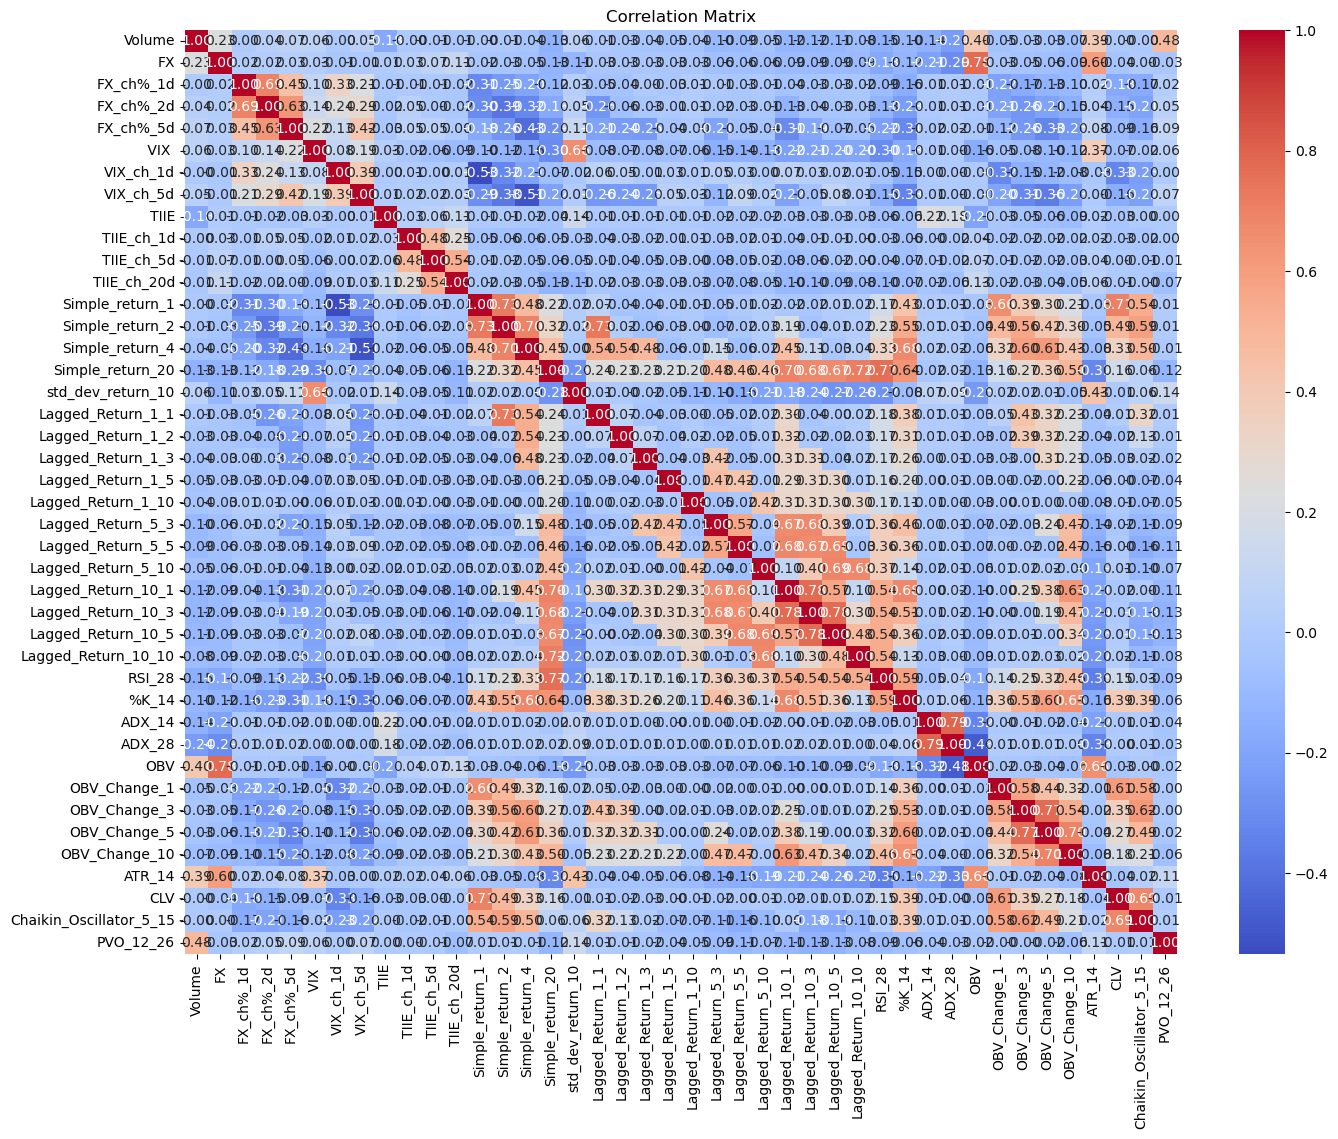

In [236]:
# Recheck the correlation matrix
corr_matrix_reduced = df_reduced.drop(columns=exclude_cols).corr()


# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_reduced, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [237]:
corr_matrix_reduced.shape

(42, 42)

In [238]:
# Identify highly correlated features in the reduced data
high_corr_pairs_reduced = get_highly_correlated_features(corr_matrix_reduced, threshold=0.70)

# Print highly correlated pairs
print("Highly correlated pairs (reduced):\n", high_corr_pairs_reduced)

Highly correlated pairs (reduced):
 ADX_28               ADX_14                 0.791850
ADX_14               ADX_28                 0.791850
FX                   OBV                    0.776816
OBV                  FX                     0.776816
Lagged_Return_10_3   Lagged_Return_10_5     0.775786
Lagged_Return_10_5   Lagged_Return_10_3     0.775786
Lagged_Return_10_3   Lagged_Return_10_1     0.775631
Lagged_Return_10_1   Lagged_Return_10_3     0.775631
OBV_Change_5         OBV_Change_3           0.773181
OBV_Change_3         OBV_Change_5           0.773181
Simple_return_20     RSI_28                 0.765381
RSI_28               Simple_return_20       0.765381
Lagged_Return_1_1    Simple_return_2        0.731959
Simple_return_2      Lagged_Return_1_1      0.731959
                     Simple_return_1        0.729455
Simple_return_1      Simple_return_2        0.729455
Simple_return_20     Lagged_Return_10_10    0.716248
Lagged_Return_10_10  Simple_return_20       0.716248
Simple_ret

In [239]:
# Verify if the key columns are still in the DataFrame
for col in ['return_category', 'Date', 'forward_return','Close']:
    if col not in df_reduced.columns:
        print(f"'{col}' is missing in the reduced DataFrame. Adding it back.")
        df_reduced[col] = df_inputs[col]

'Close' is missing in the reduced DataFrame. Adding it back.


In [240]:
# Save the final reduced DataFrame
save_directory = "/Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/"
base_name = "V2_processed_data_reduced_inputs"

save_data(df_reduced, save_directory, base_name)

Data saved to /Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/V2_processed_data_reduced_inputs_20240725_1833.csv
